# Here we visualize the distribution of the 5 drugs that were most overreprestented in our comparison between live and dead patients

In [1]:
spark

Intitializing Scala interpreter ...

Spark Web UI available at http://localhost:4040
SparkContext available as 'sc' (version = 2.3.2, master = local[*], app id = local-1559390606125)
SparkSession available as 'spark'


res0: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@32dc6701


In [2]:
%run "src/scala/register_tables.scala"

In [3]:
register_tables(spark, "spark-warehouse/")
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import spark.implicits._

===Prescription dataset===
registering patients
registering prescriptions
registering drugs
ok!
===Hospitalization dataset===
registering all
registering patients
registering prescriptions
registering drugs
ok!
===NPR Elders===
ok!
+--------+--------------------------+-----------+
|database|tableName                 |isTemporary|
+--------+--------------------------+-----------+
|        |elders                    |true       |
|        |elders_drugs              |true       |
|        |elders_patients           |true       |
|        |elders_prescriptions      |true       |
|        |npr_elders                |true       |
|        |prescription_drugs        |true       |
|        |prescription_patients     |true       |
|        |prescription_prescriptions|true       |
+--------+--------------------------+-----------+

done!


import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import spark.implicits._


### Get all patients that are dead (That have a death timestamp)
* Assign each of their prescriptions to a "bucket" of type (DRUGCODE, DATEDIFF) based on the time between the prescription date  and the death date

In [4]:
val pwd = spark.sql("select * from elders").where("death_timestamp is not null and timestamp is not null")

pwd: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 21 more fields]


* Define Spark UDF which converts the date difference to a bucket


In [5]:
import org.apache.spark.sql.functions
import java.sql.Timestamp


val toBucket = (a:Integer) => {
    val buckets = (30 to 2000 by 30).toList.reverse
    buckets.find(v => a>v)
}

val assign_bucket =udf{ toBucket }


import org.apache.spark.sql.functions
import java.sql.Timestamp
toBucket: Integer => Option[Int] = <function1>
assign_bucket: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,IntegerType,Some(List(IntegerType)))


### Define computation that generates our bucketed dataset

In [6]:
println(pwd.count)

val dead_drug_bucketed_with_count = pwd.withColumn(
        "diff_death_presc"
        ,assign_bucket(datediff(col("death_timestamp"),col("timestamp")))
    )//.select("drugcode","diff_death_presc","death_timestamp","timestamp")
    .select("drugcode","diff_death_presc")
    
    .groupBy("drugcode", "diff_death_presc").count
    .sort("drugcode","diff_death_presc")
dead_drug_bucketed_with_count.printSchema
dead_drug_bucketed_with_count.count

8972091
root
 |-- drugcode: string (nullable = true)
 |-- diff_death_presc: integer (nullable = true)
 |-- count: long (nullable = false)



dead_drug_bucketed_with_count: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [drugcode: string, diff_death_presc: int ... 1 more field]
res1: Long = 44205


In [7]:
dead_drug_bucketed_with_count.show

+--------+----------------+-----+
|drugcode|diff_death_presc|count|
+--------+----------------+-----+
| A01AA01|            null|   83|
| A01AA01|              30|   56|
| A01AA01|              60|   67|
| A01AA01|              90|   63|
| A01AA01|             120|   80|
| A01AA01|             150|   83|
| A01AA01|             180|   88|
| A01AA01|             210|   74|
| A01AA01|             240|   81|
| A01AA01|             270|   82|
| A01AA01|             300|   85|
| A01AA01|             330|   92|
| A01AA01|             360|   94|
| A01AA01|             390|  101|
| A01AA01|             420|   93|
| A01AA01|             450|   99|
| A01AA01|             480|  108|
| A01AA01|             510|  113|
| A01AA01|             540|  119|
| A01AA01|             570|  123|
+--------+----------------+-----+
only showing top 20 rows



### The dataset now contains ~44k lines, where each subset of approximately 1500/30 lines contain all buckets for a given drug

In [8]:
dead_drug_bucketed_with_count.count

res3: Long = 44205


In [9]:
dead_drug_bucketed_with_count.show(10)

+--------+----------------+-----+
|drugcode|diff_death_presc|count|
+--------+----------------+-----+
| A01AA01|            null|   83|
| A01AA01|              30|   56|
| A01AA01|              60|   67|
| A01AA01|              90|   63|
| A01AA01|             120|   80|
| A01AA01|             150|   83|
| A01AA01|             180|   88|
| A01AA01|             210|   74|
| A01AA01|             240|   81|
| A01AA01|             270|   82|
+--------+----------------+-----+
only showing top 10 rows



#### Idea for visualization from 
https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

### We take only a subset of the drugs that are used disproportionately by patients who die
* These are retreived from the 20181102 analysis

In [10]:
val plottabledrugs = List("N05CD08", "L01CA04", "L02BB04", "H02AB02", "L01AX03" )

dead_drug_bucketed_with_count.where($"drugcode".isin(plottabledrugs:_*)).createOrReplaceTempView("drugsforhistplot")

plottabledrugs: List[String] = List(N05CD08, L01CA04, L02BB04, H02AB02, L01AX03)


In [11]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
from src.python.helpers import plotfig_magic
import numpy as np
from IPython.display import Image
import tempfile

# Plot how the drugs that are used the most disproportionately - by patients that die - distribute in time (prior to the death of the patient)
* Note that the observed drugs don't occur frequently at all

In [12]:
%%python
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import tempfile


# Magic function which converts currently plotted data into an actual image
# This is required for Spylon_kernel
def plotfig_magic():
    fo = tempfile.NamedTemporaryFile(suffix=".png", mode="w")
    fo.close()
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0, rect=[0, 0.04, 1, 0.96])
    plt.savefig(fo.name)
    return Image(filename=fo.name)

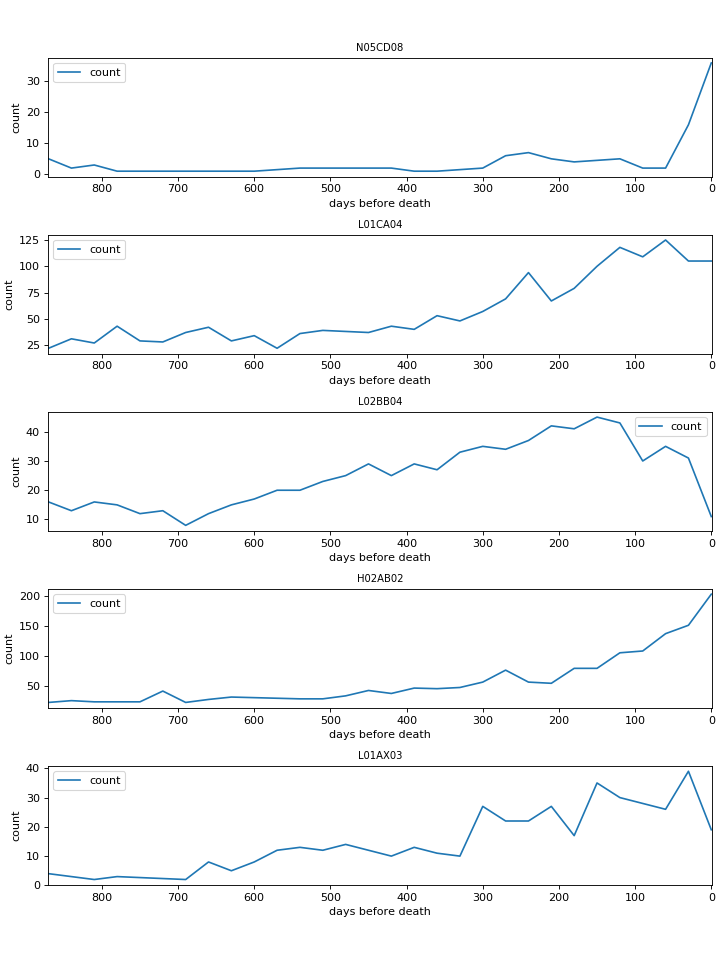

In [24]:
%%python


plt.clf()
fig = plt.figure(figsize=(9,12), dpi=80)

#title = fig.suptitle(
#    "Drug prescription occurrence, days before death, 30-day aggregates",
#    fontsize=13
#)


axes = []
rows = 5
columns = 1
for i in range(1,6):
    axes.append(fig.add_subplot(rows, columns, i))
df = spark.sql("select * from drugsforhistplot").toPandas()
#print(df)
codes = ["N05CD08", "L01CA04", "L02BB04", "H02AB02", "L01AX03"]
ax = None
#print(df[:5])
for i in range(len(codes)):
    c = codes[i]
    df_part = df.where(df["drugcode"]==c ).where(df["diff_death_presc"] <= 901).dropna()
    df_part["days_before_death"]=df_part["diff_death_presc"]
    df_part["x"] = df_part["days_before_death"]-30
    df_part.plot(ax=axes[i]
                 ,x="x"
                 ,y="count"
                 ,title=c
                )
    axes[i].set_xlim(871,-1)
    axes[i].set_title(c, fontsize=9)
    axes[i].set_xlabel("days before death")
    axes[i].set_ylabel("count")
    

retval=plotfig_magic()

In [14]:
%%python
c = codes[0]
df_part = df.where(df["drugcode"]==c ).where(df["diff_death_presc"] <= 901).dropna()
print(df_part)

    drugcode  diff_death_presc  count
199  N05CD08              30.0   36.0
200  N05CD08              60.0   16.0
201  N05CD08              90.0    2.0
202  N05CD08             120.0    2.0
203  N05CD08             150.0    5.0
204  N05CD08             210.0    4.0
205  N05CD08             240.0    5.0
206  N05CD08             270.0    7.0
207  N05CD08             300.0    6.0
208  N05CD08             330.0    2.0
209  N05CD08             390.0    1.0
210  N05CD08             420.0    1.0
211  N05CD08             450.0    2.0
212  N05CD08             570.0    2.0
213  N05CD08             630.0    1.0
214  N05CD08             660.0    1.0
215  N05CD08             750.0    1.0
216  N05CD08             810.0    1.0
217  N05CD08             840.0    3.0
218  N05CD08             870.0    2.0
219  N05CD08             900.0    5.0
